In [1]:
! pip install scipy
! pip install torch

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model for Proofread data

In [23]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import json
import torch

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
# Custom Dataset Class
class FlowersDataset(tf.keras.utils.Sequence):
    def __init__(self, image_dir, embedding_dir, batch_size=64, image_size=64):
        self.image_dir = image_dir
        self.embedding_dir = embedding_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_files = os.listdir(image_dir)
        self.embedding_files = os.listdir(embedding_dir)
        
    def __len__(self):
        return len(self.image_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_image_files = self.image_files[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images = []
        batch_embeddings = []
        
        for image_file in batch_image_files:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, image_file)
            image = Image.open(img_path).convert("RGB")
            image = image.resize((self.image_size, self.image_size)) #  Image_Size= 64x64
            image = np.array(image, dtype=np.float32) / 127.5 - 1  # Normalize to [-1, 1]
            batch_images.append(image)
            
            # Load corresponding embedding
            embedding_file = image_file.replace('.jpg', '.npy')
            embedding_path = os.path.join(self.embedding_dir, embedding_file)
            embedding = np.load(embedding_path)
            batch_embeddings.append(embedding)
        
        return np.array(batch_embeddings), np.array(batch_images)

In [42]:
# Updated Generator
def make_generator_model(noise_dim, embedding_dim):
    combined_dim = noise_dim + embedding_dim
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(combined_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 512)))

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


In [43]:
# Updated Discriminator
def make_discriminator_model(embedding_dim):
    image_input = tf.keras.layers.Input(shape=(64, 64, 3))
    embedding_input = tf.keras.layers.Input(shape=(embedding_dim,))

    x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)

    embedding_x = tf.keras.layers.Dense(128)(embedding_input)
    embedding_x = tf.keras.layers.LeakyReLU(0.2)(embedding_x)

    combined = tf.keras.layers.Concatenate()([x, embedding_x])

    x = tf.keras.layers.Dense(128)(combined)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[image_input, embedding_input], outputs=output)

In [44]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [45]:
# Training step
@tf.function
def train_step(images, embeddings):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])
    combined_input = tf.concat([noise, embeddings], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(combined_input, training=True)

        real_output = discriminator([images, embeddings], training=True)
        fake_output = discriminator([generated_images, embeddings], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [46]:
# Function to save models
def save_models(save_dir, epoch):
    generator.save(os.path.join(save_dir, f'generator_epoch_{epoch}.h5'))
    discriminator.save(os.path.join(save_dir, f'discriminator_epoch_{epoch}.h5'))
    print(f"Models saved for epoch {epoch}")

# Function to load models (for future inference)
def load_models(save_dir, epoch):
    generator = tf.keras.models.load_model(os.path.join(save_dir, f'generator_epoch_{epoch}.h5'))
    discriminator = tf.keras.models.load_model(os.path.join(save_dir, f'discriminator_epoch_{epoch}.h5'))
    return generator, discriminator

In [47]:
# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def preprocess_images_for_inception(images):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return images

In [48]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # Get InceptionV3 predictions
    preds = inception_model.predict(preprocess_images_for_inception(images))
    
    # Calculate mean KL divergence
    scores = []
    n_part = images.shape[0] // n_split
    for i in range(n_split):
        part = preds[i * n_part:(i+1) * n_part]
        kl = part * (np.log(part + eps) - np.log(np.expand_dims(np.mean(part, 0), 0) + eps))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

In [49]:
def calculate_fid(real_images, generated_images):
    # Calculate activation statistics for real and generated images
    act1 = inception_model.predict(preprocess_images_for_inception(real_images))
    act2 = inception_model.predict(preprocess_images_for_inception(generated_images))
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # Calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [50]:
def evaluate_gan(generator, dataset, num_images=1000):
    # Generate images in batches
    generated_images = []
    real_images = []
    num_batches = num_images // BATCH_SIZE + (1 if num_images % BATCH_SIZE != 0 else 0)
    
    for _ in range(num_batches):
        embeddings, images = next(iter(dataset))
        batch_size = embeddings.shape[0]
        noise = tf.random.normal([batch_size, noise_dim])
        combined_input = tf.concat([noise, embeddings], axis=1)
        generated_batch = generator(combined_input, training=False)
        
        generated_images.append(generated_batch)
        real_images.append(images)
    
    generated_images = tf.concat(generated_images, axis=0)[:num_images]
    real_images = tf.concat(real_images, axis=0)[:num_images]
    
    # Calculate Inception Score
    is_mean, is_std = calculate_inception_score(generated_images)
    
    # Calculate FID
    fid = calculate_fid(real_images, generated_images)
    
    return is_mean, is_std, fid

In [51]:
# Training loop
def train(dataset, epochs, save_dir, eval_interval=10):
    generator_losses = []
    discriminator_losses = []
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(epochs):
        gen_losses_epoch = []
        disc_losses_epoch = []
        for embedding_batch, image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, embedding_batch)
            gen_losses_epoch.append(gen_loss.numpy())
            disc_losses_epoch.append(disc_loss.numpy())

        avg_gen_loss = np.mean(gen_losses_epoch)
        avg_disc_loss = np.mean(disc_losses_epoch)
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}')
        
        generate_and_save_images(generator, epoch + 1, seed, fixed_embeddings)

        if (epoch + 1) % eval_interval == 0:
            is_mean, is_std, fid = evaluate_gan(generator, dataset)
            print(f'Epoch {epoch+1}, Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')
        
        if (epoch + 1) % 100 == 0:
            save_models(save_dir, epoch + 1) #Save model for every 100 epochs

    save_models(save_dir, 'final')
    save_losses(save_dir, generator_losses, discriminator_losses)
    # Final evaluation
    is_mean, is_std, fid = evaluate_gan(generator, dataset)
    print(f'Final Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')
    return generator_losses, discriminator_losses


In [52]:
# Function to convert any float32 to float in the losses
def convert_to_float(obj):
    if isinstance(obj, np.float32):  # If the object is a float32, convert it to Python float
        return float(obj)
    elif isinstance(obj, list):  # If it's a list, apply the function recursively
        return [convert_to_float(item) for item in obj]
    elif isinstance(obj, dict):  # If it's a dictionary, apply it to all values
        return {key: convert_to_float(value) for key, value in obj.items()}
    else:
        return obj

In [53]:
# Function to save losses
def save_losses(save_dir, generator_losses, discriminator_losses):
    losses = {
        'generator': generator_losses,
        'discriminator': discriminator_losses
    }
    losses = convert_to_float(losses)
    with open(os.path.join(save_dir, 'losses.json'), 'w') as f:
        json.dump(losses, f)

In [54]:
# Updated generate_and_save_images function
def generate_and_save_images(model, epoch, test_input, test_embeddings):
    predictions_folder=r'C:\Predictions_raw'
    # Ensure the folder exists, if not create it
    os.makedirs(predictions_folder, exist_ok=True)
    image_filename = 'image_at_epoch_{:04d}.png'.format(epoch)
    image_save_path = os.path.join(predictions_folder, image_filename)
    combined_input = tf.concat([test_input, test_embeddings], axis=1)
    predictions = model(combined_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) * 0.5)  # Denormalize
        plt.axis('off')

    plt.savefig(image_save_path)
    plt.close()

In [55]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dim = 768  # This should match your actual embedding dimension

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\tamil_embeddings_300_raw",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_raw_500'
epochs=500
# Start training

generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)



Epoch 1, Gen Loss: 0.7757, Disc Loss: 0.7889
Epoch 2, Gen Loss: 1.7155, Disc Loss: 0.3002
Epoch 3, Gen Loss: 2.1769, Disc Loss: 0.2238
Epoch 4, Gen Loss: 2.6973, Disc Loss: 0.1991
Epoch 5, Gen Loss: 3.1417, Disc Loss: 0.1500
Epoch 6, Gen Loss: 2.8493, Disc Loss: 0.1293
Epoch 7, Gen Loss: 2.7091, Disc Loss: 0.1413
Epoch 8, Gen Loss: 2.5444, Disc Loss: 0.2516
Epoch 9, Gen Loss: 2.3509, Disc Loss: 0.2789
Epoch 10, Gen Loss: 3.5374, Disc Loss: 0.1178
Epoch 11, Gen Loss: 4.0235, Disc Loss: 0.0366
Epoch 12, Gen Loss: 4.3959, Disc Loss: 0.0213
Epoch 13, Gen Loss: 4.2419, Disc Loss: 0.0197
Epoch 14, Gen Loss: 4.5985, Disc Loss: 0.0197
Epoch 15, Gen Loss: 4.2572, Disc Loss: 0.0422
Epoch 16, Gen Loss: 4.5542, Disc Loss: 0.0539
Epoch 17, Gen Loss: 4.8313, Disc Loss: 0.0551
Epoch 18, Gen Loss: 4.1008, Disc Loss: 0.0860
Epoch 19, Gen Loss: 3.5081, Disc Loss: 0.1560
Epoch 20, Gen Loss: 2.8441, Disc Loss: 0.2052
Epoch 21, Gen Loss: 3.0277, Disc Loss: 0.1096
Epoch 22, Gen Loss: 3.7615, Disc Loss: 0.05

In [19]:
def generate_images(generator, num_images, noise_dim, embedding_dim):
    # Generate random noise
    noise = tf.random.normal([num_images, noise_dim])
    
    # Generate random embeddings (in a real scenario, you'd use actual embeddings)
    random_embeddings = tf.random.normal([num_images, embedding_dim])
    
    # Concatenate noise and embeddings
    combined_input = tf.concat([noise, random_embeddings], axis=1)
    
    # Generate images
    generated_images = generator(combined_input, training=False)
    
    # Denormalize the images (assuming they were normalized to [-1, 1])
    generated_images = (generated_images + 1) / 2.0
    
    return generated_images

In [20]:
def load_losses(save_dir):
    with open(os.path.join(save_dir, 'losses.json'), 'r') as f:
        losses = json.load(f)
    return losses['generator'], losses['discriminator']

# Function to visualize losses
def plot_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Muril without proofread

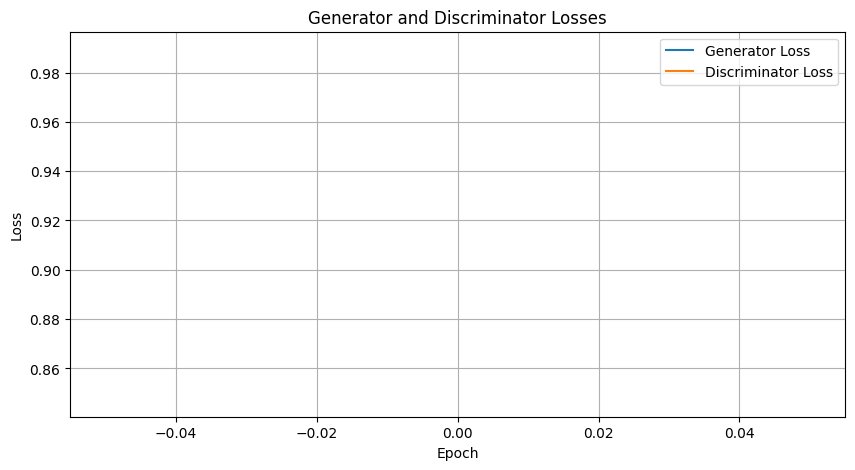

32/32 [==============================] - 17s 546ms/step
Loaded Model Evaluation - Inception Score: 1.0006 ± 0.0000, FID: 16.9510


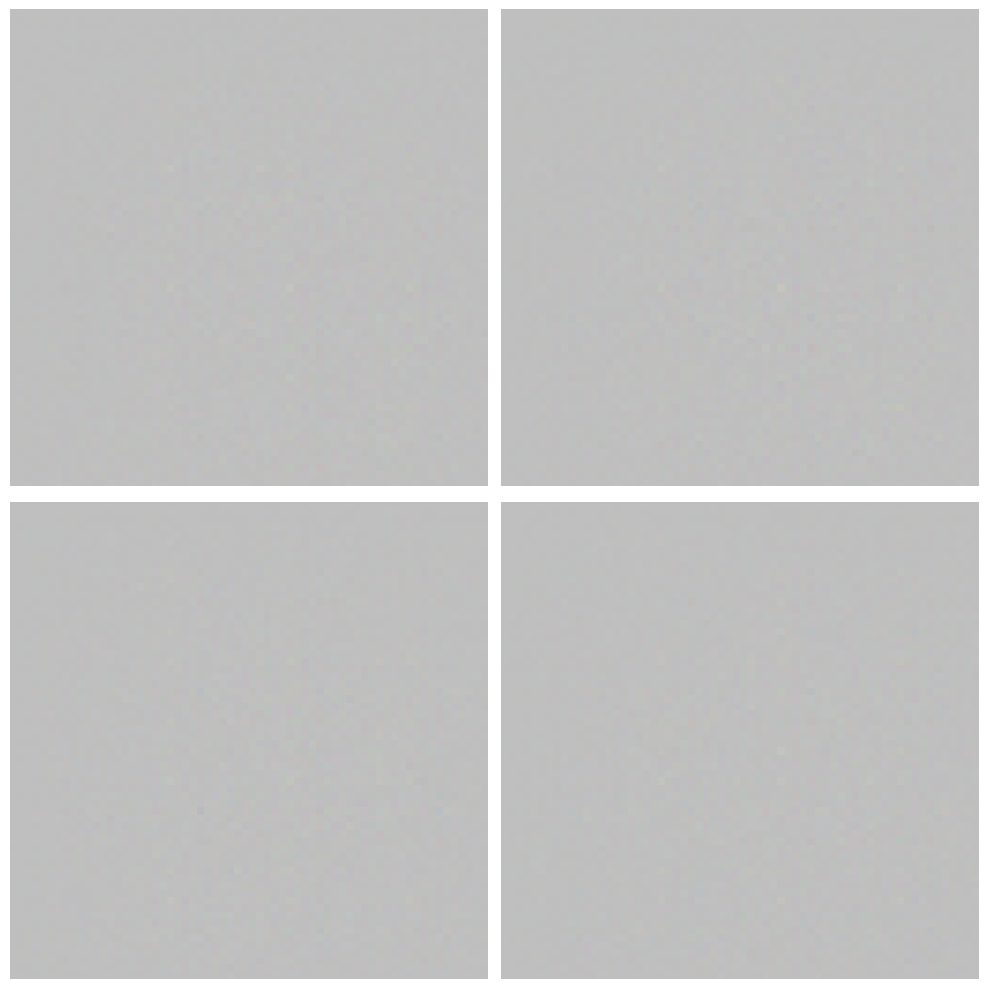

In [21]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Muril with Proofread

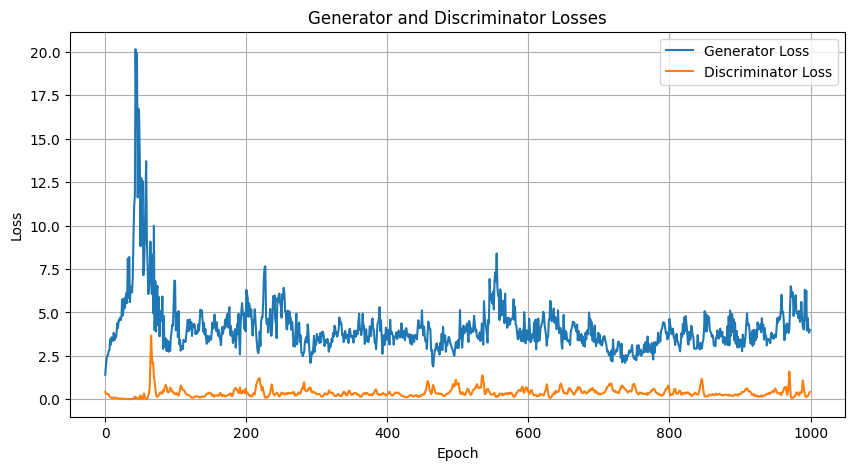

32/32 [==============================] - 44s 1s/step
Loaded Model Evaluation - Inception Score: 1.0005 ± 0.0000, FID: 17.0298


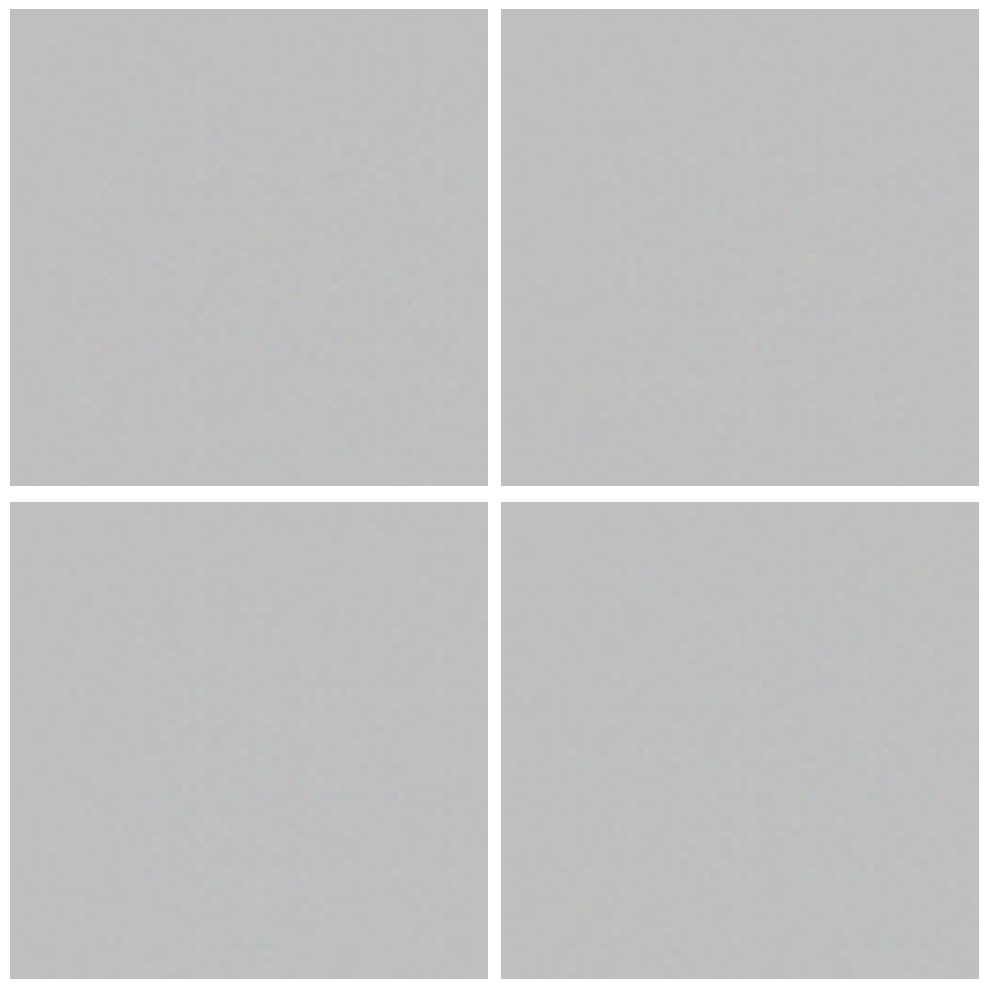

In [39]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()